In [1]:
using QuantumCollocation
using NamedTrajectories
using TrajectoryIndexingUtils
using Flux
using ReinforcementLearning
using IntervalSets
using LinearAlgebra
using Base
using Distributions
using Statistics
using Printf
using Reexport
using Revise
using DomainSets
using CairoMakie

includet("PPO.jl")
includet("AIRL.jl")
includet("GateEnvs.jl")

In [2]:
RZ_traj = load_traj("RZ_pretrained.jld2")

const Units = 1e9
const MHz = 1e6 / Units
const GHz = 1e9 / Units
const ns = 1e-9 * Units
const μs = 1e-6 * Units
;


# Operators
const Paulis = Dict(
    "I" => Matrix{ComplexF64}([1 0; 0 1]),
    "X" => Matrix{ComplexF64}([0 1; 1 0]),
    "Y" => Matrix{ComplexF64}([0 im; -im 0]),
    "Z" => Matrix{ComplexF64}([1 0; 0 -1]),
)

rz_op(theta) = exp(-im/2 * theta[1] * Paulis["Z"]);

RZ = Gate(1,rz_op)

H_drives = [
     Paulis["X"],Paulis["Y"]
]
system = QuantumSystem(H_drives);
t_f = 10* ns
n_steps = 51
times = range(0, t_f, n_steps)  # Alternative: collect(0:Δt:t_f)
n_controls=1
n_qubits=1;
Δt = times[2] - times[1]

N = 11
;

In [3]:
Pretraining_Env = GatePretrainingEnv(
                                    system,
                                    n_steps,
                                    RZ,
                                    Δt,
                                    N,
                                    RZ_traj;
                                    dda_bound=1.5
                                    )
pretraining_𝒫 = ActorCriticPolicy(Pretraining_Env;)
pretraining_bc_𝒫 = ActorCriticPolicy(Pretraining_Env;)
load_policy(pretraining_𝒫,"initial_policy.jld2")
load_policy(pretraining_bc_𝒫,"bc_policy.jld2")

ActorCriticPolicy(Chain(Dense(14 => 128, tanh), Dense(128 => 128, tanh)), Dense(128 => 2, tanh), Dense(128 => 1, log_std_clip), Chain(Dense(14 => 128, tanh), Dense(128 => 128, tanh), Dense(128 => 1)))

In [4]:
expert_states = Vector{Vector{Float32}}()
expert_acts = Vector{Vector{Float32}}()
expert_new_states = Vector{Vector{Float32}}()
for idx in 1:11
    for t in 1:48
        angle = range(0,2*pi,11)[idx]
        a = RZ_traj[Symbol("a"*string(idx))][:,t]
        da = RZ_traj[Symbol("da"*string(idx))][:,t]
        dda = RZ_traj[Symbol("dda"*string(idx))][:,t]
        U = RZ_traj[Symbol(Unicode.normalize("Ũ⃗"*string(idx)))][:,t]
        push!(expert_states, vcat(U,da,a,[t/51],angle))
        push!(expert_acts, dda)
        if(t>1)
          push!(expert_new_states, expert_states[end])
        end
        if(t==48)
            angle = range(0,2*pi,11)[idx]
            a = RZ_traj[Symbol("a"*string(idx))][:,51]
            da = RZ_traj[Symbol("da"*string(idx))][:,51]
            dda = RZ_traj[Symbol("dda"*string(idx))][:,51]
            U = RZ_traj[Symbol(Unicode.normalize("Ũ⃗"*string(idx)))][:,51]
            push!(expert_new_states, vcat(U,da,a,[49/51],angle))

        end
    end
end


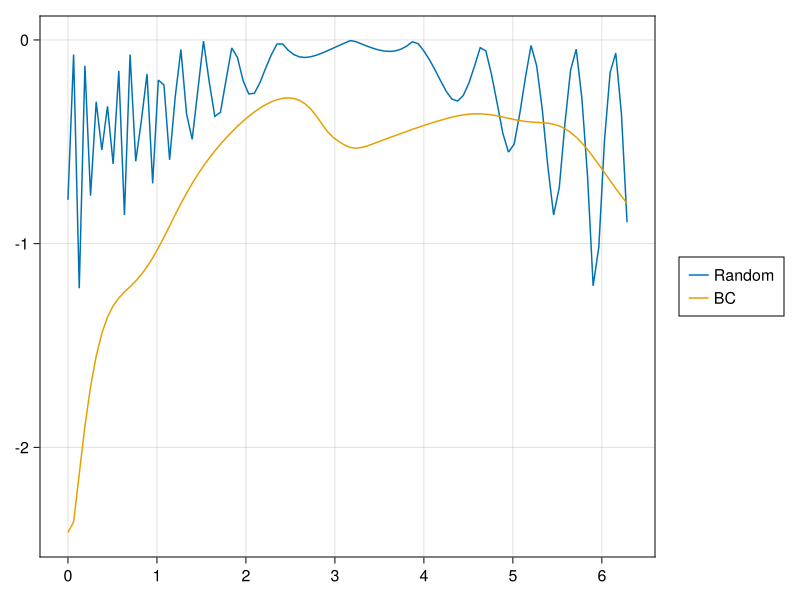

In [5]:
fig = Figure()
infid_data = policy_sample(Pretraining_Env,pretraining_𝒫,100)
infid_data1 = policy_sample(Pretraining_Env,pretraining_bc_𝒫,100)
ax = Axis(fig[1, 1])
l = lines!(ax,range(0,2π,length(infid_data)),log10.(infid_data))
l1 = lines!(ax,range(0,2π,length(infid_data1)),log10.(infid_data1))
Legend(fig[1, 2],
    [l, l1],
    ["Random", "BC"])
fig

In [6]:
AIRL_pretraining_𝒫,score_history,e_losses,s_losses,total_d_losses = AIRL(Pretraining_Env,expert_states,expert_acts,expert_new_states;η=3f-5,iterations=500,n_steps=1,trajectory_batch_size=11,vf_ratio=5f-1,norm_adv = true,ϵ= 2f-1,ent_ratio=1f-3,KL_targ=5f-2,initial_policy=pretraining_𝒫,clip_grad_tresh=1f3,use_log_rewards=false)

Iterations 1 Complete
Updates 80
Avg Score: -53.94465
Total Steps: 528
Total Trajectories: 11
Final KL: 0.02105
Mean Policy Loss: 0.01378
Mean Value Loss: 305.64426
Mean Entropy: 2.47621
Mean ADV: -5.03961
Mean Clip Ratio: 0.10312
Mean Discriminator Score: -1.72470
Start Discriminator Score: -2.08081
End Discriminator Score: -1.22752
Discriminator Updates: 80
Discriminator Sampled: 0.51362
Discriminator Expert: 0.90023
-------------------------
Iterations 2 Complete
Updates 80
Avg Score: -67.11726
Total Steps: 528
Total Trajectories: 11
Final KL: 0.02248
Mean Policy Loss: 0.01249
Mean Value Loss: 3330.03198
Mean Entropy: 2.51513
Mean ADV: 3.46129
Mean Clip Ratio: 0.05176
Mean Discriminator Score: -1.86736
Start Discriminator Score: -2.00037
End Discriminator Score: -1.68760
Discriminator Updates: 80
Discriminator Sampled: 0.52080
Discriminator Expert: 0.81785
-------------------------
Iterations 3 Complete
Updates 80
Avg Score: -56.30148
Total Steps: 528
Total Trajectories: 11
Final KL

LoadError: InterruptException:

In [ ]:
AIRL_bc_pretraining_𝒫,bc_score_history,bc_e_losses,bc_s_losses,bc_total_d_losses = AIRL(Pretraining_Env,expert_states,expert_acts,expert_new_states;η=3f-5,iterations=500,n_steps=1,trajectory_batch_size=11,vf_ratio=5f-1,norm_adv = true,ϵ= 2f-1,ent_ratio=1f-3,KL_targ=5f-2,initial_policy=pretraining_bc_𝒫,clip_grad_tresh=1f3,use_log_rewards=false)

Iterations 1 Complete
Updates 80
Avg Score: -55.73535
Total Steps: 528
Total Trajectories: 11
Final KL: 0.01068
Mean Policy Loss: 0.01998
Mean Value Loss: 4469.37646
Mean Entropy: 2.96909
Mean ADV: 39.27960
Mean Clip Ratio: 0.06191
Mean Discriminator Score: -3.15959
Start Discriminator Score: -3.17392
End Discriminator Score: -2.93341
Discriminator Updates: 40
Discriminator Sampled: 0.88342
Discriminator Expert: 0.85266
-------------------------
Iterations 2 Complete
Updates 80
Avg Score: -66.80663
Total Steps: 528
Total Trajectories: 11
Final KL: 0.00901
Mean Policy Loss: 0.01371
Mean Value Loss: 2382.21094
Mean Entropy: 2.91548
Mean ADV: 29.35116
Mean Clip Ratio: 0.03574
Mean Discriminator Score: -2.71895
Start Discriminator Score: -2.83254
End Discriminator Score: -2.11645
Discriminator Updates: 40
Discriminator Sampled: 0.79998
Discriminator Expert: 0.75132
-------------------------
Iterations 3 Complete
Updates 80
Avg Score: -58.01017
Total Steps: 528
Total Trajectories: 11
Final 

In [ ]:
fig = Figure()
infid_data = policy_sample(Pretraining_Env,AIRL_pretraining_𝒫,100)
infid_data1 = policy_sample(Pretraining_Env,AIRL_bc_pretraining_𝒫,100)
ax = Axis(fig[1, 1])
l = lines!(ax,range(0,2π,length(infid_data)),log10.(infid_data))
l1 = lines!(ax,range(0,2π,length(infid_data1)),log10.(infid_data1))
Legend(fig[1, 2],
    [l, l1],
    ["Random", "BC"])
fig

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1])
l = lines!(ax,1:length(score_history),score_history)
l1 = lines!(ax,1:length(bc_score_history),bc_score_history)
Legend(fig[1, 2],
    [l, l1],
    ["Random", "BC"])
fig

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1])
l = lines!(ax,1:length(e_losses),e_losses)
l1 = lines!(ax,1:length(bc_e_losses),bc_e_losses)
Legend(fig[1, 2],
    [l, l1],
    ["Random", "BC"])
fig

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1])
l = lines!(ax,1:length(s_losses),s_losses)
l1 = lines!(ax,1:length(bc_s_losses),bc_s_losses)
Legend(fig[1, 2],
    [l, l1],
    ["Random", "BC"])
fig

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1])
l = lines!(ax,1:length(total_d_losses),total_d_losses)
l1 = lines!(ax,1:length(bc_total_d_losses),bc_total_d_losses)
Legend(fig[1, 2],
    [l, l1],
    ["Random", "BC"])
fig